In [1]:
import pandas as pd
import wrangle as w
import explore as e
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split

from functools import reduce

import matplotlib.pyplot as plt

## Recreate model data from model.ipynb notebook

In [2]:
# acquire dataframe
df = w.get_perpetrator_df()

# create production dataframe based on the target variables
production_df = df[df['gname'].str.contains('Unknown')==True]

# create target variable dataframe
df1 = df[df['gname'].str.contains('Unknown')==False]

# drop columns from the dataframe that arent relevant in the predictor
model_df = df1.drop(columns=['event_id',
             'month',
             'day',
             'region',
             'latitude',
             'longitude',
             'success',
             'attacktype_n',
             'targtype_n',
             'targsubtype_n',
             'targsubtype',
             'corp1',
             'target_description',
             'nationality',
             'claimed',
             'weapdesc',
             'nkill',
             'nkillus',
             'nkillter',
             'nwound',
             'nwoundus',
             'nwoundte',
             'property'])


# change year to object type
model_df.year = model_df.year.astype('str')

# create a dataframe for the gname target variable
gnames = pd.DataFrame(model_df.gname)

# encode variables
dummy_df = pd.get_dummies(model_df[['country',
                                    'provstate',
                                    'city',
                                    'suicide',
                                    'attack_type', 
                                    'targtype',  
                                    'weaptype',
                                    'year']], dummy_na=False, drop_first=[True, True])


# add target to dataframe
dummy_df = dummy_df.merge(gnames, how='inner', left_on=dummy_df.index,
                          right_on=gnames.index)

# rename popped off index
dummy_df = dummy_df.rename(columns={'key_0':'date'})

# drop previous index, date column
dummy_df = dummy_df.drop(columns=['date'])
dummy_df.head()

suicide  country_bahrain  country_djibouti  country_egypt  country_iran  \
0        0                0                 0              0             0   
1        1                0                 0              0             0   
2        0                0                 0              0             0   
3        0                0                 0              0             0   
4        0                0                 0              0             0   

   country_iraq  country_israel  country_jordan  country_lebanon  \
0             1               0               0                0   
1             0               0               0                0   
2             0               0               0                0   
3             0               0               0                0   
4             0               0               0                0   

   country_pakistan  country_saudi arabia  country_somalia  country_syria  \
0                 0                     0                0              0   
1                 0                     0                0              0   
2                 0                     0                0              0   
3                 0                     0                0              0   
4                 0                     0                0              0   

   country_turkey  provstate_Adiyaman  provstate_Agri  provstate_Al Anbar  \
0               0                   0               0                   0   
1               0                   0               0                   0   
2               0                   0               0                   0   
3               0                   0               0                   0   
4               0                   0               0                   0   

   provstate_Al Hasakah  provstate_Al Qadisiyah  provstate_Al Sharqia  \
0                     0                       0                     0   
1                     0                       0                     0   
2                     0                       0                     0   
3                     0                       0                     0   
4                     0                       0                     0   

   provstate_Aleppo  provstate_Amman  provstate_Ankara  provstate_Antalya  \
0                 0                0                 0                  0   
1                 0                0                 0                  0   
2                 0                0                 0                  0   
3                 0                0                 0                  0   
4                 0                0                 0                  0   

   provstate_Arbil  provstate_Ardahan  provstate_Artvin  provstate_As Suwayda  \
0                0                  0                 0                     0   
1                0                  0                 0                     0   
2                0                  0                 0                     0   
3                0                  0                 0                     0   
4                0                  0                 0                     0   

   provstate_Asir  provstate_At Tamim  provstate_Azad Kashmir  \
0               0                   0                       0   
1               0                   0                       0   
2               0                   0                       0   
3               0                   0                       0   
4               0                   0                       0   

   provstate_Babil  provstate_Badakhshan  provstate_Badghis  \
0                0                     0                  0   
1                0                     0                  0   
2                0                     0                  0   
3                0                     0                  0   
4                0                     0                  0   

   provstate_Baghdad  provstate_Baghlan 

### TTS

In [3]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [4]:
# split into train, validate, test
train, validate, test = train_validate_test_split(dummy_df, target='gname', seed=123)

# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['gname'])
y_train = train.gname

X_validate = validate.drop(columns=['gname'])
y_validate = validate.gname

X_test = test.drop(columns=['gname'])
y_test = test.gname

In [5]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=50, random_state=123)

# model.fit(X, y)

clf = clf.fit(X_train, y_train)

# make prediction on train obeservations

y_pred = clf.predict(X_train)

y_pred_proba = clf.predict_proba(X_train)

# Eval model
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.64


In [6]:
metrics = []
for i in range(1, 15):
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    tree = tree.fit(X_train, y_train)
    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
dt_df = pd.DataFrame(metrics)
dt_df["difference"] = dt_df.train_accuracy - dt_df.validate_accuracy
dt_df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.458103,0.458195,-0.000092
1,2,0.516828,0.520232,-0.003404
2,3,0.524157,0.526028,-0.001871
3,4,0.532360,0.533934,-0.001574
4,5,0.537175,0.538800,-0.001625
5,6,0.542557,0.543165,-0.000608
6,7,0.553581,0.553540,0.000041
7,8,0.557414,0.555436,0.001978
8,9,0.560404,0.558298,0.002106
9,10,0.563501,0.560409,0.003092


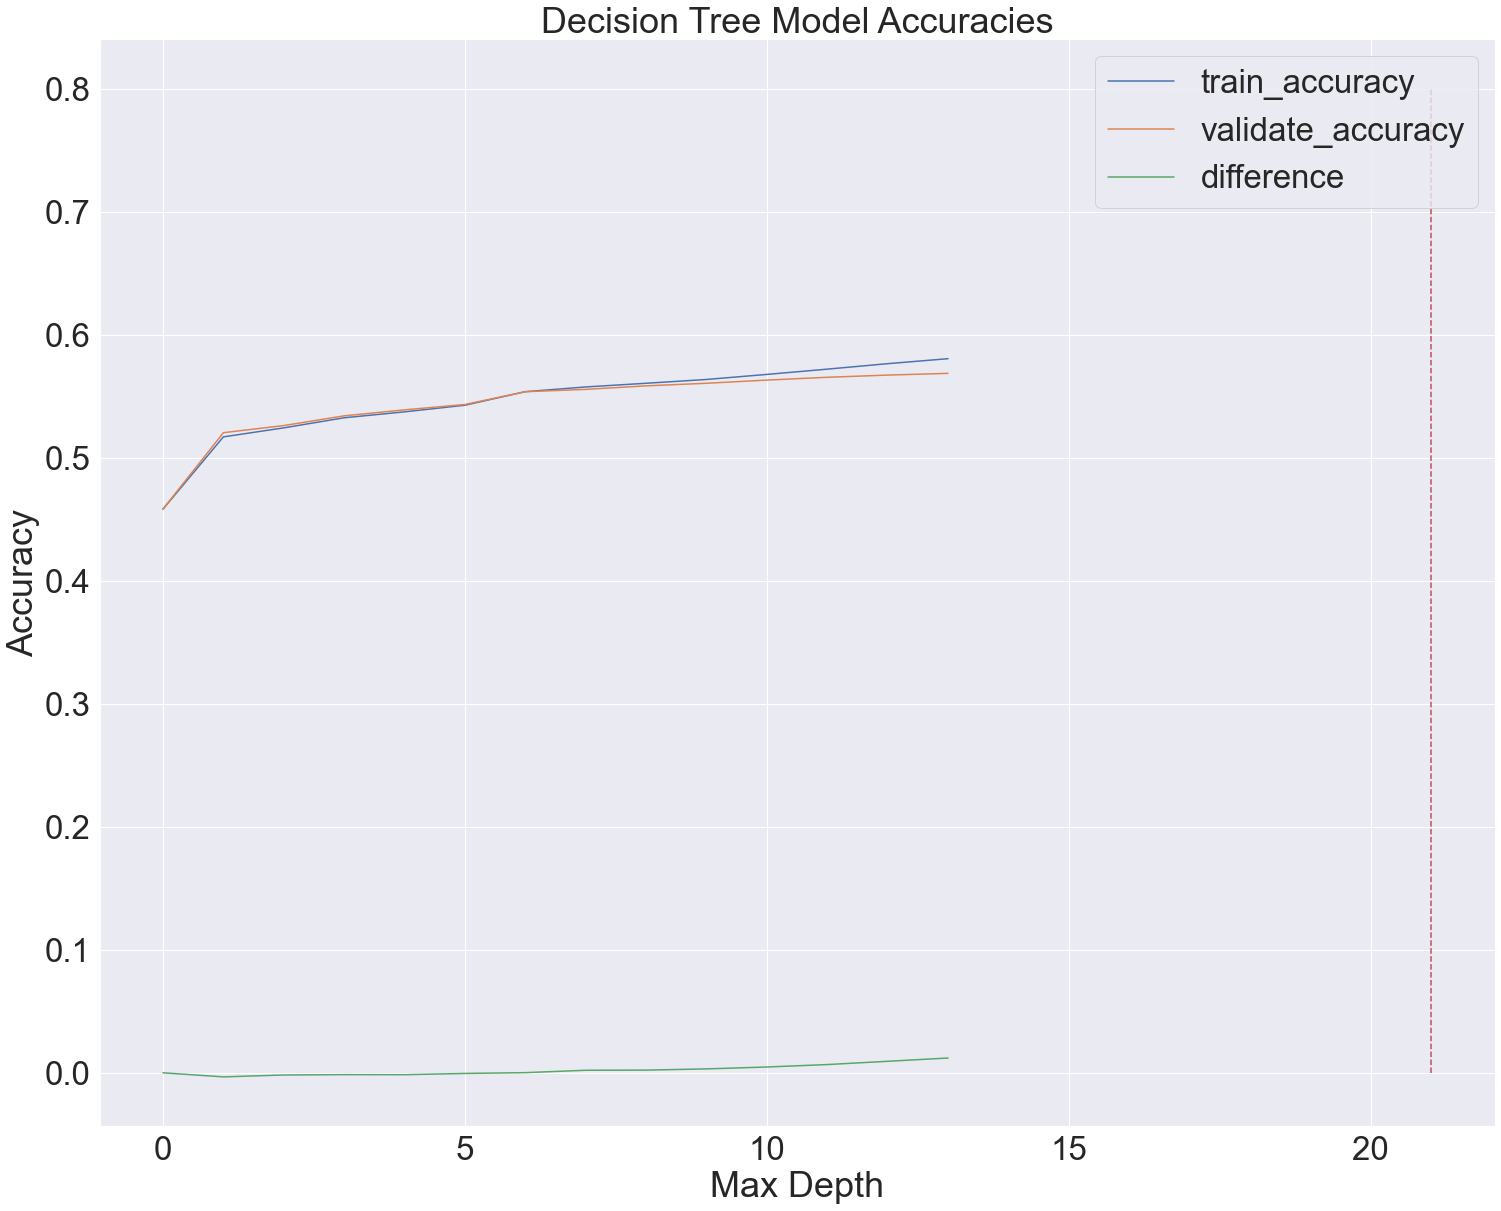

In [7]:
plt.rcParams['figure.figsize'] = [25, 20]
sns.set(font_scale = 3)
dt_df[['train_accuracy', 'validate_accuracy', 'difference' ]].plot()
plt.title("Decision Tree Model Accuracies")
plt.ylabel("Accuracy")
plt.xlabel("Max Depth")
plt.vlines(x=[21], ymin=0, ymax=.8, colors='r', linestyles='dashed')
plt.show()